Importação Bibliotecas

In [ ]:
from subprocess import Popen, PIPE, TimeoutExpired
import pandas as pd
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
from scipy.stats import norm
from math import pi

Importação Dataset

In [ ]:
from subprocess import Popen, PIPE, TimeoutExpired

cmd = """git clone https://github.com/eduardohg/nba_analysis nba_analysis"""
proc = Popen(cmd.split(" "), stdout = PIPE, stderr = PIPE)

In [ ]:
import pandas as pd

games = pd.read_csv('/content/nba_analysis/nba__dataset/games.csv')
games_details = pd.read_csv('/content/nba_analysis/nba__dataset/games_details.csv', dtype={"NICKNAME": "string"})
players = pd.read_csv('/content/nba_analysis/nba__dataset/players.csv')
ranking = pd.read_csv('/content/nba_analysis/nba__dataset/ranking.csv')
teams = pd.read_csv('/content/nba_analysis/nba__dataset/teams.csv')

In [ ]:
def print_missing_values(df):
    df_null = pd.DataFrame(len(df) - df.notnull().sum(), columns = ['Count'])
    df_null = df_null[df_null['Count'] > 0].sort_values(by='Count', ascending=False)
    df_null = df_null/len(df)*100

    if len(df_null) == 0:
        display(Markdown('No missing value.'))
        return

    x = df_null.index.values
    height = [e[0] for e in df_null.values]

    fig, ax = plt.subplots(figsize=(20, 5))
    ax.bar(x, height, width=0.8)
    plt.xticks(x, x, rotation=60)
    plt.xlabel('Columns')
    plt.ylabel('Percentage')
    plt.title('Percentage of missing values in columns')
    plt.show()

def dataset_overview(df, df_name):
  display(Markdown(f'dataset shape : {df.shape}'))
  display(Markdown(f'### {df_name} 5 primeiras linhas'))
  display(df.head())
  display(Markdown(f'#### Describe dataset'))
  display(df.describe().T)
  display(Markdown('*****'))
  display(Markdown(f'#### Missing values'))
  print_missing_values(df)

dataset shape : (210342, 13)

### ranking 5 primeiras linhas

,TEAM_ID,LEAGUE_ID,SEASON_ID,STANDINGSDATE,CONFERENCE,TEAM,G,W,L,W_PCT,HOME_RECORD,ROAD_RECORD,RETURNTOPLAY
0,1610612743,0,22022,2022-12-22,West,Denver,30,19,11,0.633,10-3,9-8,NaN
1,1610612763,0,22022,2022-12-22,West,Memphis,30,19,11,0.633,13-2,6-9,NaN
2,1610612740,0,22022,2022-12-22,West,New Orleans,31,19,12,0.613,13-4,6-8,NaN
3,1610612756,0,22022,2022-12-22,West,Phoenix,32,19,13,0.594,14-4,5-9,NaN
4,1610612746,0,22022,2022-12-22,West,LA Clippers,33,19,14,0.576,11-7,8-7,NaN


#### Describe dataset

,count,mean,std,min,25%,50%,75%,max
TEAM_ID,210342.0,1.610613e+09,8.641501,1.610613e+09,1.610613e+09,1.610613e+09,1.610613e+09,1.610613e+09
LEAGUE_ID,210342.0,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
SEASON_ID,210342.0,2.140105e+04,2395.250417,1.200300e+04,2.200600e+04,2.201100e+04,2.201700e+04,2.202200e+04
G,210342.0,5.665974e+01,28.644294,0.000000e+00,3.200000e+01,6.700000e+01,8.200000e+01,8.200000e+01
W,210342.0,2.833336e+01,17.268500,0.000000e+00,1.400000e+01,2.800000e+01,4.200000e+01,7.300000e+01
L,210342.0,2.832638e+01,17.260557,0.000000e+00,1.400000e+01,2.900000e+01,4.100000e+01,7.200000e+01
W_PCT,210342.0,4.928325e-01,0.187763,0.000000e+00,3.720000e-01,5.000000e-01,6.210000e-01,1.000000e+00
RETURNTOPLAY,3990.0,6.000000e-01,0.489959,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


*****

#### Missing values

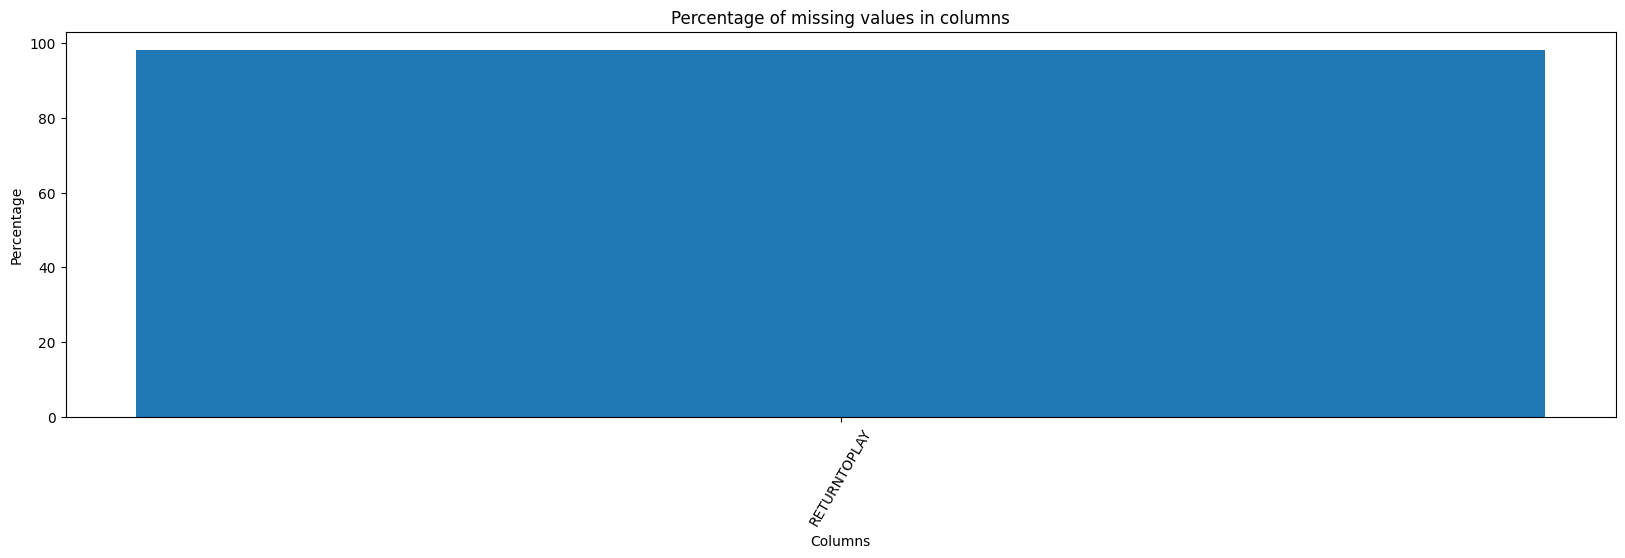

In [ ]:
# @title Overview dos Datasets
try:
  # @markdown - Forneça o dataset para ter uma overview (games, games_details, players, ranking, teams):
  dataset = 'ranking'  # @param {type: "string"}
  dataset_df = globals()[dataset]
  dataset_overview(dataset_df, dataset)
except:
  print("Forneça um dataset válido")

**As análises serão apenas considerando a temporada 2021-2022 e tirando os jogos de playoffs e pré-temporada**

**Preparação:**

In [ ]:
#ranking da temporada 2021-2022
ranking['STANDINGSDATE'] = pd.to_datetime(ranking['STANDINGSDATE'])

#obter os dados só após todos os 82 jogos da temporada
ranking_final = ranking[ranking['G'] == 82]
#a id da temporada 2021-2022 é 22021
ranking_final = ranking_final[ranking_final['SEASON_ID'] == 22021]

#ordenar o dataframe com os times em suas posições corretas e adicionar a coluna da colocação
indices_max_data  = ranking_final.groupby('TEAM')['STANDINGSDATE'].idxmax()
ranking_final = ranking_final.loc[indices_max_data].sort_values(by='W',ascending=False)
ranking_final.insert(0,"Colocação",np.arange(1,31))

In [ ]:
#merge dataset com os dados de jogos com o dataset dos dados do time (para obter o nome dos times dentro do dataset de jogos)

games = pd.merge(games, teams, left_on='HOME_TEAM_ID', right_on='TEAM_ID', how='left')
games = pd.merge(games, teams, left_on='VISITOR_TEAM_ID', right_on='TEAM_ID', how='left',suffixes=('_ANFITRIÃO', '_VISITANTE'))
#columns = ['NICKNAME_ANFITRIÃO', 'NICKNAME_VISITANTE', 'PTS_home', 'PTS_away', 'GAME_DATE_EST']
#games[columns]

In [ ]:
games['GAME_DATE_EST'] = pd.to_datetime(games['GAME_DATE_EST'])

#apenas jogos da temporada 2021-2022
games_temp = games[games['SEASON']==2021]

#retira jogos de playoffs
games_temp = games_temp[games_temp['GAME_DATE_EST'] < '2022-04-11']

#retira jogos de pre-season
games_temp = games_temp[games_temp['GAME_DATE_EST'] > '2021-10-16']

**Análises gráficas**

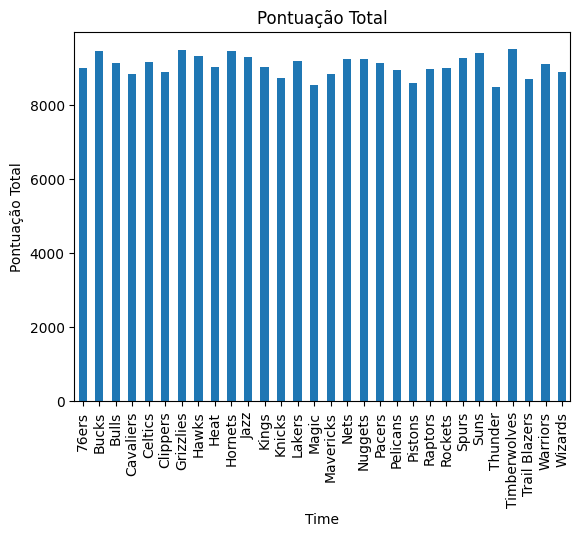

In [ ]:
#@title Gráfico de Barras da pontuação total dos times

#Gráfico de barras com a soma de pontuação dos times na temporada
home_scores = games_temp.groupby('NICKNAME_ANFITRIÃO')['PTS_home'].sum()
away_scores = games_temp.groupby('NICKNAME_VISITANTE')['PTS_away'].sum()

# Juntar as pontuações de casa e de visitante
total_scores = home_scores.add(away_scores, fill_value=0)

# Criar o gráfico de barras
total_scores.plot(kind='bar')
plt.xlabel('Time')
plt.ylabel('Pontuação Total')
plt.title('Pontuação Total')
plt.show()

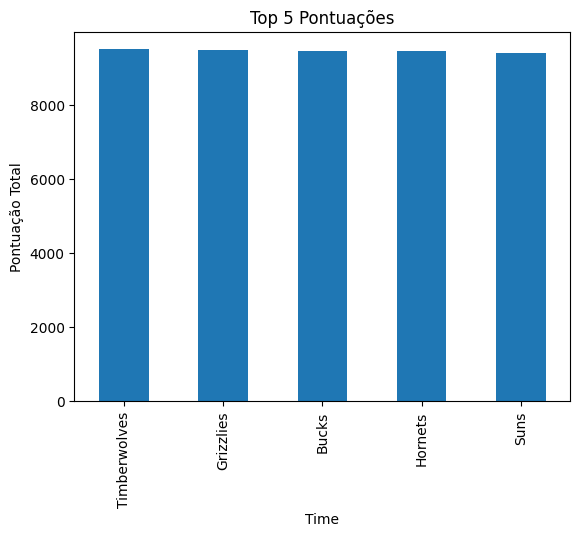

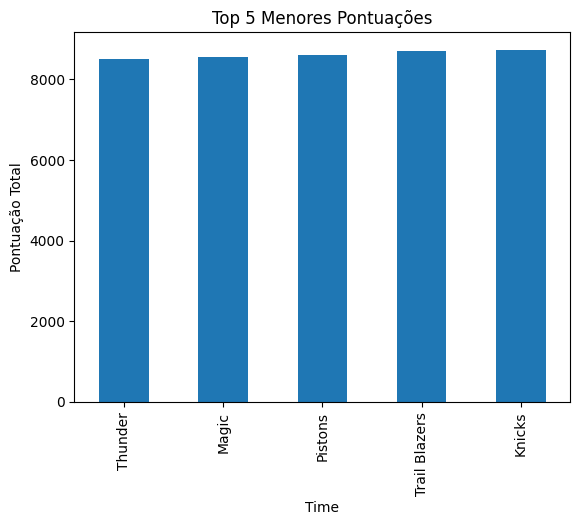

In [ ]:
#@title Gráfico de Barras Top 5 maiores e menores pontuações

top_5 = total_scores.sort_values(ascending=False).head(5)

top_5.plot(kind='bar')
plt.xlabel('Time')
plt.ylabel('Pontuação Total')
plt.title('Top 5 Pontuações')
plt.show()

top_5 = total_scores.sort_values(ascending=True).head(5)

top_5.plot(kind='bar')
plt.xlabel('Time')
plt.ylabel('Pontuação Total')
plt.title('Top 5 Menores Pontuações')
plt.show()

Mean Pts Home: 111.47723577235773 Std Pts Home: 12.449340028924967
Mean Pts Away: 109.75447154471544 Std Pts away:  12.725936974353068


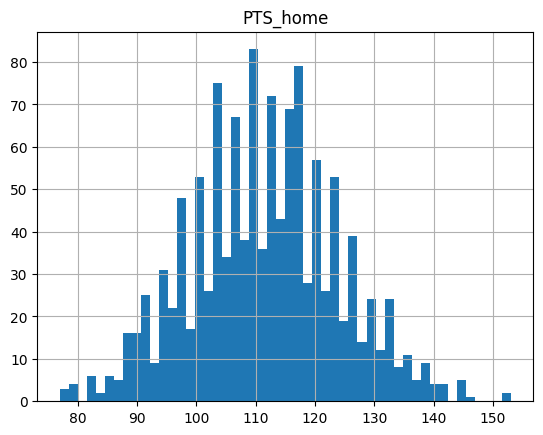

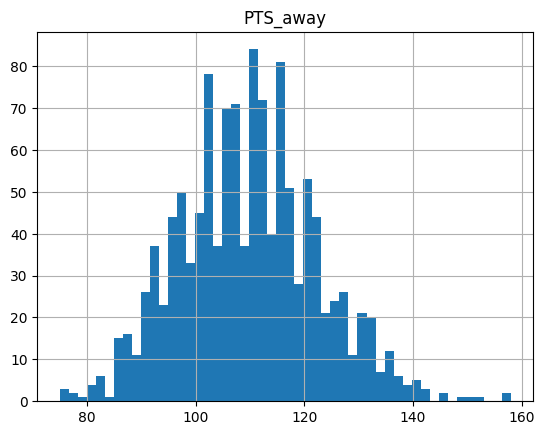

In [ ]:
#@title Histograma de pontos dos times jogando em casa e jogando fora

games_temp.hist(column='PTS_home',bins=50)
games_temp.hist(column='PTS_away',bins=50)

mean_asth = np.mean(games_temp["PTS_home"])
std_asth=np.std(games_temp["PTS_home"])
print ("Mean Pts Home:",mean_asth,"Std Pts Home:",std_asth)

mean_asta = np.mean(games_temp["PTS_away"])
std_asta=np.std(games_temp["PTS_away"])

print ("Mean Pts Away:",mean_asta,"Std Pts away: ",std_asta)

Mean Ast Home: 25.046341463414635 Std Ast Home: 5.0505057733191006
Mean Ast Away: 24.25121951219512 Std Ast away:  4.954867293369604


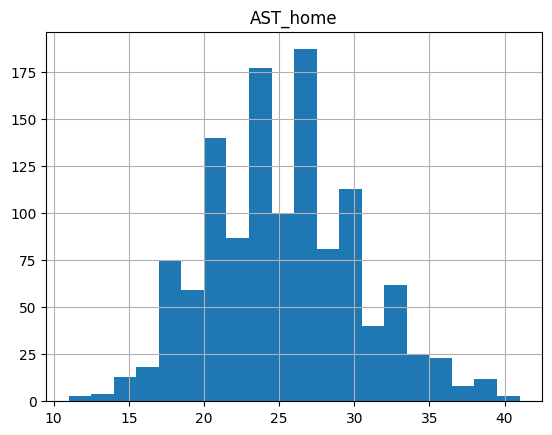

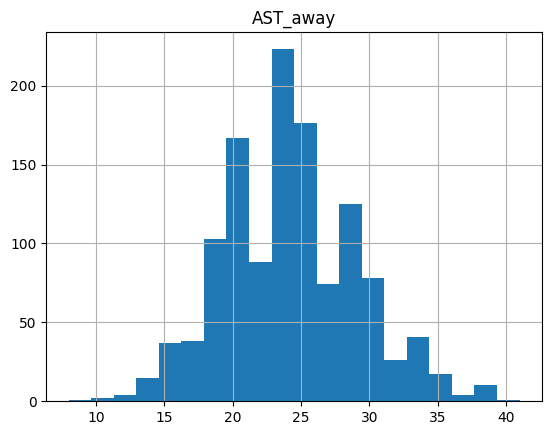

In [ ]:
#@title Histograma de assistências dos times jogando em casa e jogando fora

games_temp.hist(column='AST_home',bins=20)
games_temp.hist(column='AST_away',bins=20)
mean_asth = np.mean(games_temp["AST_home"])
std_asth=np.std(games_temp["AST_home"])
print ("Mean Ast Home:",mean_asth,"Std Ast Home:",std_asth)

mean_asta = np.mean(games_temp["AST_away"])
std_asta=np.std(games_temp["AST_away"])

print ("Mean Ast Away:",mean_asta,"Std Ast away: ",std_asta)

In [ ]:
#Merge dataset com informações de games com o dataset do ranking
games_temp = pd.merge(games_temp, ranking_final, left_on='HOME_TEAM_ID', right_on='TEAM_ID', how='left')
games_temp = pd.merge(games_temp, ranking_final, left_on='VISITOR_TEAM_ID', right_on='TEAM_ID', how='left',suffixes=('_ANFITRIÃO', '_VISITANTE'))

<ipython-input-16-a06dbdc47270>:3: FutureWarning: Passing 'suffixes' which cause duplicate columns {'TEAM_ID_ANFITRIÃO', 'LEAGUE_ID_ANFITRIÃO'} in the result is deprecated and will raise a MergeError in a future version.
  games_temp = pd.merge(games_temp, ranking_final, left_on='VISITOR_TEAM_ID', right_on='TEAM_ID', how='left',suffixes=('_ANFITRIÃO', '_VISITANTE'))


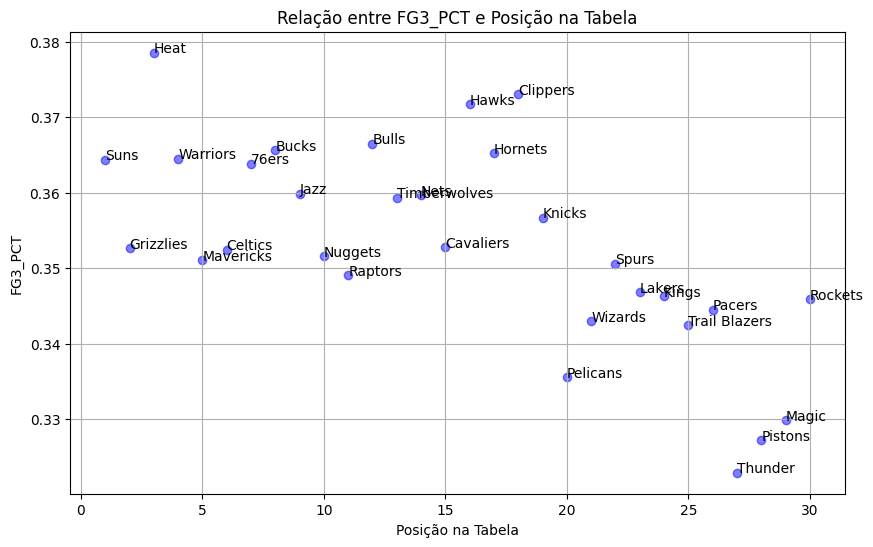

Pearson correlation coefficient; -0.6682563727809853


In [ ]:
#@title Correlação da média de 3PTS com a colocação final do campeonato usando Scatter Plot

#Criação dataframe com informações da média de %3PT de cada time e colocação final no campeonato
def medias_scatterplot(column):
  df = games_temp.groupby('NICKNAME_ANFITRIÃO').agg({column+'_home': 'mean', 'Colocação_ANFITRIÃO': 'first'}).reset_index()
  df_visitante = games_temp.groupby('NICKNAME_VISITANTE').agg({column+'_away': 'mean', 'Colocação_VISITANTE': 'first'}).reset_index()

  # Renomeando as colunas para unificar os dados dos times anfitriões e visitantes
  df = df.rename(columns={'NICKNAME_ANFITRIÃO': 'Time', column+'_home': 'media', 'Colocação_ANFITRIÃO': 'colocacao_final'})
  df_visitante = df_visitante.rename(columns={'NICKNAME_VISITANTE': 'Time', column+'_away': 'media', 'Colocação_VISITANTE': 'colocacao_final'})

  # Concatenando os DataFrames dos times anfitriões e visitantes
  df = pd.concat([df, df_visitante])

  df = df.groupby('Time').agg({'media': 'mean','colocacao_final': 'first'}).reset_index()

  plt.figure(figsize=(10, 6))
  plt.scatter(df['colocacao_final'], df['media'], color='blue', alpha=0.5)

  # Adicionar rótulos e título
  plt.title('Relação entre '+column+' e Posição na Tabela')
  plt.xlabel('Posição na Tabela')
  plt.ylabel(column)


  # Adicionar rótulos de texto para cada ponto
  for i, txt in enumerate(df['Time']):
      plt.annotate(txt, (df['colocacao_final'][i], df['media'][i]))

  # Mostrar o gráfico
  plt.grid(True)
  plt.show()

  return df

def pearson_r(x, y):
    """Compute Pearson correlation coefficient between two arrays."""
    # Compute correlation matrix: corr_mat
    corr_mat=np.corrcoef(x,y)

    # Return entry [0,1]
    return corr_mat[0,1]

df_plot = medias_scatterplot('FG3_PCT')
print("Pearson correlation coefficient;",pearson_r(df_plot["colocacao_final"],df_plot["media"]))

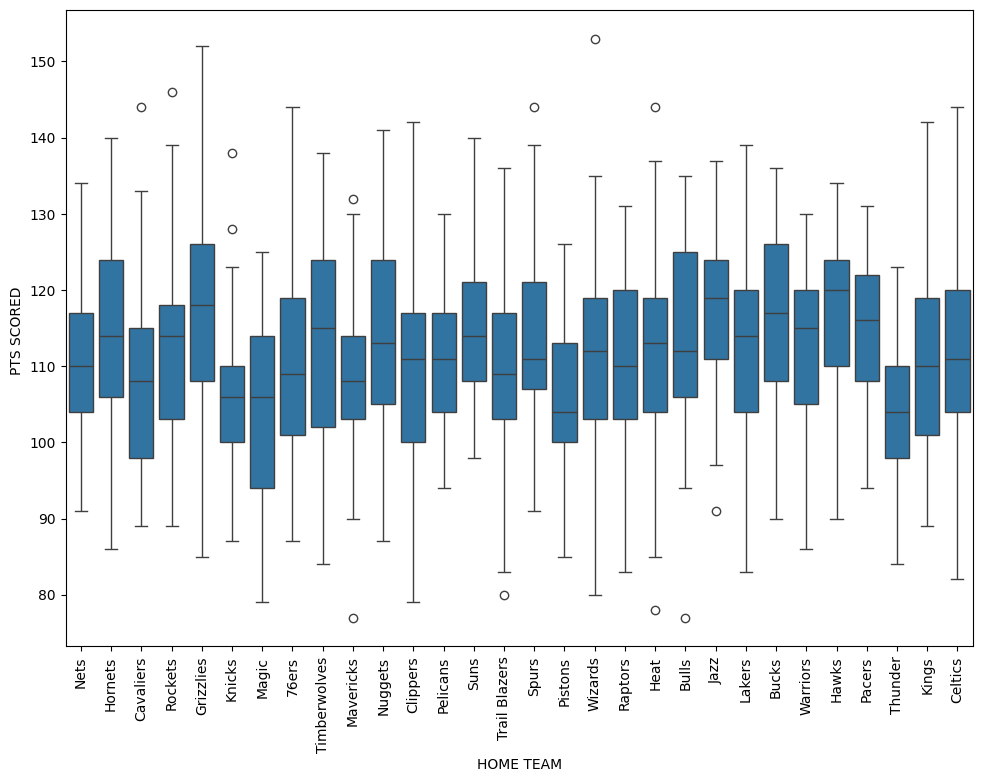

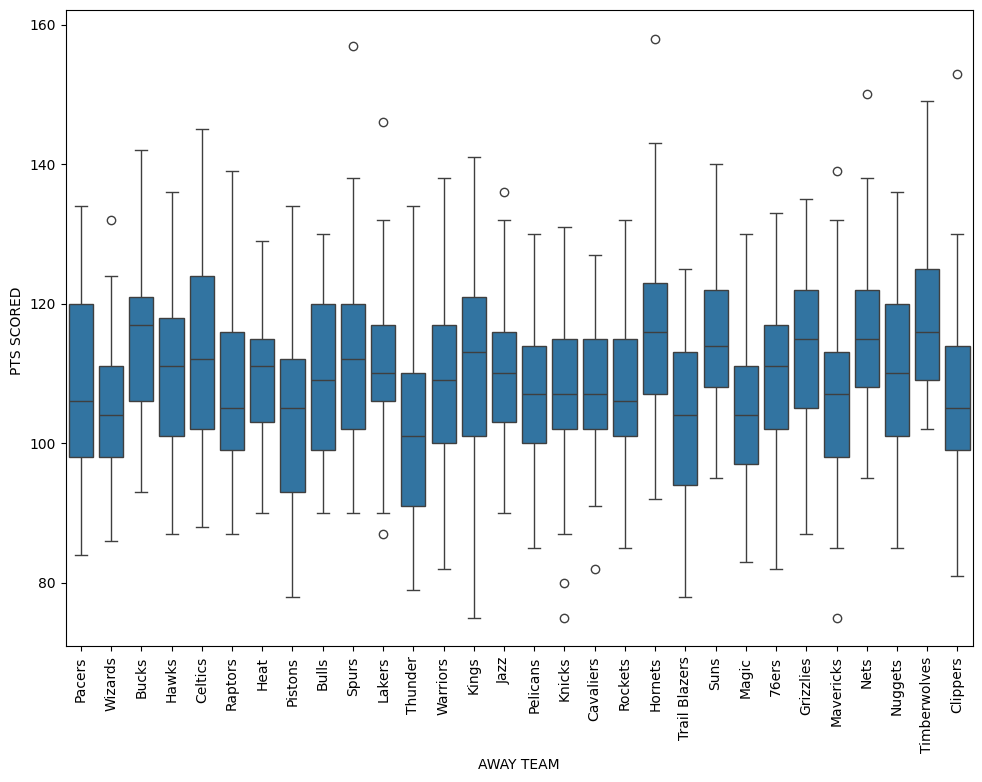

In [ ]:
#@title BoxPlot com os pontos dos times em casa e fora de casa
fig, ax = plt.subplots()

fig.set_size_inches(11.7, 8.27)

sns.boxplot(x="NICKNAME_ANFITRIÃO",y="PTS_home",data=games_temp)



plt.xlabel("HOME TEAM")
plt.xticks(rotation = 90)
plt.ylabel("PTS SCORED ")


plt.show()

fig, ax = plt.subplots()

fig.set_size_inches(11.7, 8.27)

sns.boxplot(x="NICKNAME_VISITANTE",y="PTS_away",data=games_temp)



plt.xlabel("AWAY TEAM")
plt.xticks(rotation = 90)
plt.ylabel("PTS SCORED ")


plt.show()

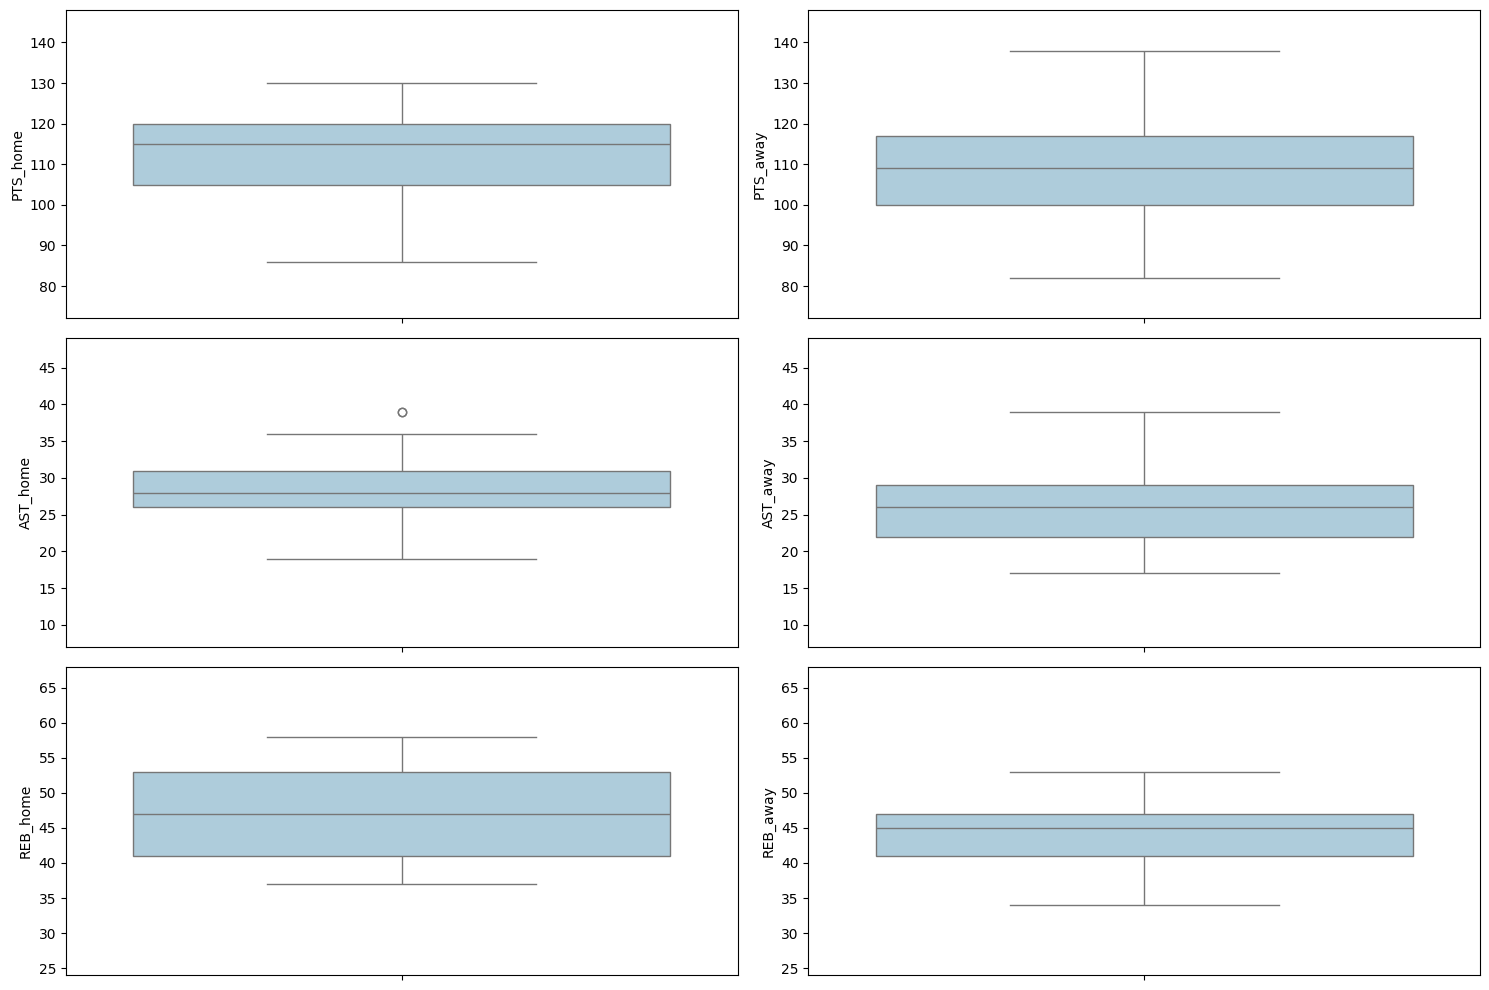

In [ ]:
# @title Estatísticas de um time através do BoxPlot

def statisticsByTeam(gms_home_team, gms_away_team):
  sns.set_palette("Paired")

  max_pts = max(gms_home_team["PTS_home"].max(), gms_away_team["PTS_away"].max())+10
  min_pts = min(gms_home_team["PTS_home"].min(), gms_away_team["PTS_away"].min())-10
  max_ast = max(gms_home_team["AST_home"].max(), gms_away_team["AST_away"].max())+10
  min_ast = min(gms_home_team["AST_home"].min(), gms_away_team["AST_away"].min())-10
  max_reb = max(gms_home_team["REB_home"].max(), gms_away_team["REB_away"].max())+10
  min_reb = min(gms_home_team["REB_home"].min(), gms_away_team["REB_away"].min())-10

  fig, axes = plt.subplots(3, 2, figsize=(15, 10), sharex=True)

  # PTS
  sns.boxplot(y="PTS_home", data=gms_home_team, ax=axes[0, 0])
  axes[0, 0].set_ylim(min_pts, max_pts)
  sns.boxplot(y="PTS_away", data=gms_away_team, ax=axes[0, 1])
  axes[0, 1].set_ylim(min_pts, max_pts)

  # AST
  sns.boxplot(y="AST_home", data=gms_home_team, ax=axes[1, 0])
  axes[1, 0].set_ylim(min_ast, max_ast)
  sns.boxplot(y="AST_away", data=gms_away_team, ax=axes[1, 1])
  axes[1, 1].set_ylim(min_ast, max_ast)

  # REB
  sns.boxplot(y="REB_home", data=gms_home_team, ax=axes[2, 0])
  axes[2, 0].set_ylim(min_reb, max_reb)
  sns.boxplot(y="REB_away", data=gms_away_team, ax=axes[2, 1])
  axes[2, 1].set_ylim(min_reb, max_reb)

  plt.tight_layout()
  plt.show()

  def statisticsByTeam(gms_home_team, gms_away_team):
    sns.set_palette("Paired")

    max_pts = max(gms_home_team["PTS_home"].max(), gms_away_team["PTS_away"].max())+10
    min_pts = min(gms_home_team["PTS_home"].min(), gms_away_team["PTS_away"].min())-10
    max_ast = max(gms_home_team["AST_home"].max(), gms_away_team["AST_away"].max())+10
    min_ast = min(gms_home_team["AST_home"].min(), gms_away_team["AST_away"].min())-10
    max_reb = max(gms_home_team["REB_home"].max(), gms_away_team["REB_away"].max())+10
    min_reb = min(gms_home_team["REB_home"].min(), gms_away_team["REB_away"].min())-10

    fig, axes = plt.subplots(3, 2, figsize=(15, 10), sharex=True)

    # PTS
    sns.boxplot(y="PTS_home", data=gms_home_team, ax=axes[0, 0])
    axes[0, 0].set_ylim(min_pts, max_pts)
    sns.boxplot(y="PTS_away", data=gms_away_team, ax=axes[0, 1])
    axes[0, 1].set_ylim(min_pts, max_pts)

    # AST
    sns.boxplot(y="AST_home", data=gms_home_team, ax=axes[1, 0])
    axes[1, 0].set_ylim(min_ast, max_ast)
    sns.boxplot(y="AST_away", data=gms_away_team, ax=axes[1, 1])
    axes[1, 1].set_ylim(min_ast, max_ast)

    # REB
    sns.boxplot(y="REB_home", data=gms_home_team, ax=axes[2, 0])
    axes[2, 0].set_ylim(min_reb, max_reb)
    sns.boxplot(y="REB_away", data=gms_away_team, ax=axes[2, 1])
    axes[2, 1].set_ylim(min_reb, max_reb)

    plt.tight_layout()
    plt.show()

# @markdown - Forneça um nome de um time para ter as estatísticas:
team = 'Warriors'  # @param {type: "string"}

gms_home_team = games_temp[games_temp['NICKNAME_ANFITRIÃO'] == team]
gms_away_team = games_temp[games_temp['NICKNAME_VISITANTE'] == team]

statisticsByTeam(gms_home_team, gms_away_team)

In [ ]:
#@title Funções para a criação do gráfico de radar entre dois jogadores

stats_cols = {
    'FGM':'Field Goals Made',
    'FGA':'Field Goals Attempted',
    'FG_PCT':'Field Goal Percentage',
    'FG3M':'Three Pointers Made',
    'FG3A':'Three Pointers Attempted',
    'FG3_PCT':'Three Point Percentage',
    'FTM':'Free Throws Made',
    'FTA':'Free Throws Attempted',
    'FT_PCT':'Free Throw Percentage',
    'OREB':'Offensive Rebounds',
    'DREB':'Defensive Rebounds',
    'REB':'Rebounds',
    'AST':'Assists',
    'TO':'Turnovers',
    'STL':'Steals',
    'BLK':'Blocked Shots',
    'PF':'Personal Foul',
    'PTS':'Points',
    'PLUS_MINUS':'Plus-Minus'
}

def rename_df(df, col_dict):
  cols = df.columns
  new_cols = [(col_dict[c] if c in col_dict else c) for c in cols]
  df.columns = new_cols
  return df

def compare_players(player_one, player_two):

  stats_players_pct = ['FG_PCT','FG3_PCT', 'FT_PCT']
  stats_players_oth = ['REB', 'AST', 'STL', 'PF', 'BLK']

  pl_one_df = games_details[games_details['PLAYER_NAME'] == player_one]
  pl_two_df = games_details[games_details['PLAYER_NAME'] == player_two]

  player_one_pct_agg = pl_one_df[stats_players_pct].agg(['mean'])
  player_one_oth_agg = pl_one_df[stats_players_oth].agg(['mean'])


  player_two_pct_agg = pl_two_df[stats_players_pct].agg(['mean'])
  player_two_oth_agg = pl_two_df[stats_players_oth].agg(['mean'])

  stats_pct = pd.concat([player_one_pct_agg, player_two_pct_agg])
  stats_oth = pd.concat([player_one_oth_agg, player_two_oth_agg])

  stats_pct.index = [player_one, player_two]
  stats_oth.index = [player_one, player_two]

  stats_pct = rename_df(stats_pct, col_dict=stats_cols)
  stats_oth = rename_df(stats_oth, col_dict=stats_cols)

  return stats_pct, stats_oth

def radar_plot(ax, df, max_val=1):
    # number of variable
    categories=list(df)
    N = len(categories)

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='black', size=12)

    # Draw ylabels
    ax.set_rlabel_position(0)
    yticks = [max_val*i/4 for i in range(1,4)]
    plt.yticks(yticks, [str(e) for e in yticks], color="grey", size=10)
    plt.ylim(0,max_val)

    # We are going to plot the first line of the data frame.
    # But we need to repeat the first value to close the circular graph:
    colors = ['b','r','g']
    for i in range(len(df)):
        values = df.values[i].flatten().tolist()
        values += values[:1]
        color = colors[i]

        # Plot data
        ax.plot(angles, values, linewidth=1, linestyle='solid', color=color, label=df.index[i])

        # Fill area
        ax.fill(angles, values, color, alpha=0.1)

    # Add legend
    plt.legend(loc=0, bbox_to_anchor=(0.1, 0.1), prop={'size': 13})

<ipython-input-22-1587155132da>:10: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(121, polar=True)


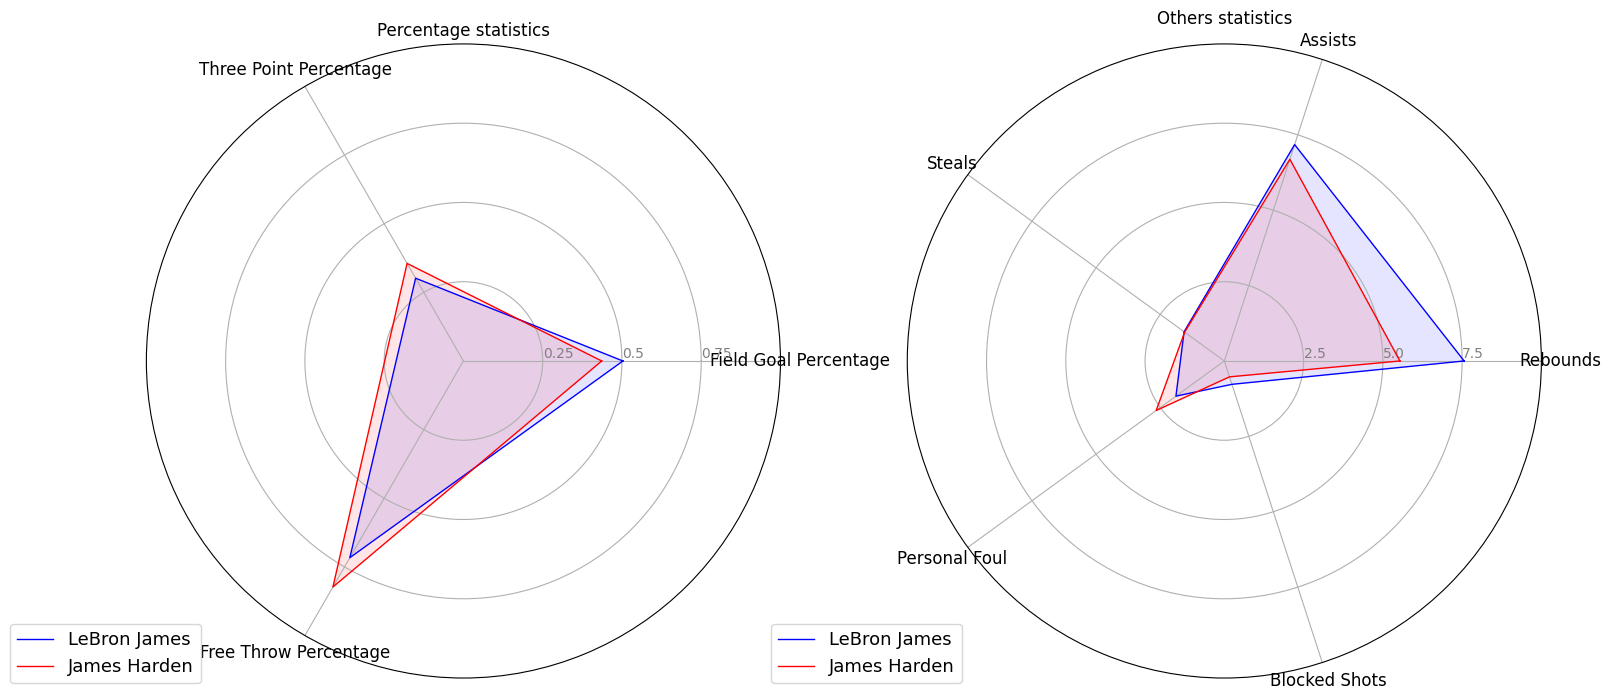

In [ ]:
#@title Comparação Entre Players (All Time)

player_one = 'LeBron James'  # @param {type: "string"}
player_two = 'James Harden' # @param {type: "string"}


stats_pct, stats_oth = compare_players(player_one, player_two)
fig, ax = plt.subplots(figsize=(18, 9))

ax = plt.subplot(121, polar=True)
ax.set_title('Percentage statistics')
radar_plot(ax=ax, df=stats_pct, max_val=1)

ax = plt.subplot(122, polar=True)
ax.set_title('Others statistics')
radar_plot(ax=ax, df=stats_oth, max_val=10)

plt.show()